<a href="https://colab.research.google.com/github/su-sumico/seminar/blob/main/lstm_air_pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTMによる大気汚染予測

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* インポート

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime

import math
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Deep learning/lstm/air-quality-india.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36192 entries, 0 to 36191
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  36192 non-null  object 
 1   Year       36192 non-null  int64  
 2   Month      36192 non-null  int64  
 3   Day        36192 non-null  int64  
 4   Hour       36192 non-null  int64  
 5   PM2.5      36192 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.7+ MB


* pandas.to_datetime()関数を使うと、日時（日付・時間）を表した文字列の列pandas.Seriesをdatetime64[ns]型に変換できます。

In [ ]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [ ]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


In [ ]:
df['Date']=df["Timestamp"].dt.date

* 可視化

* 日ごとの時系列

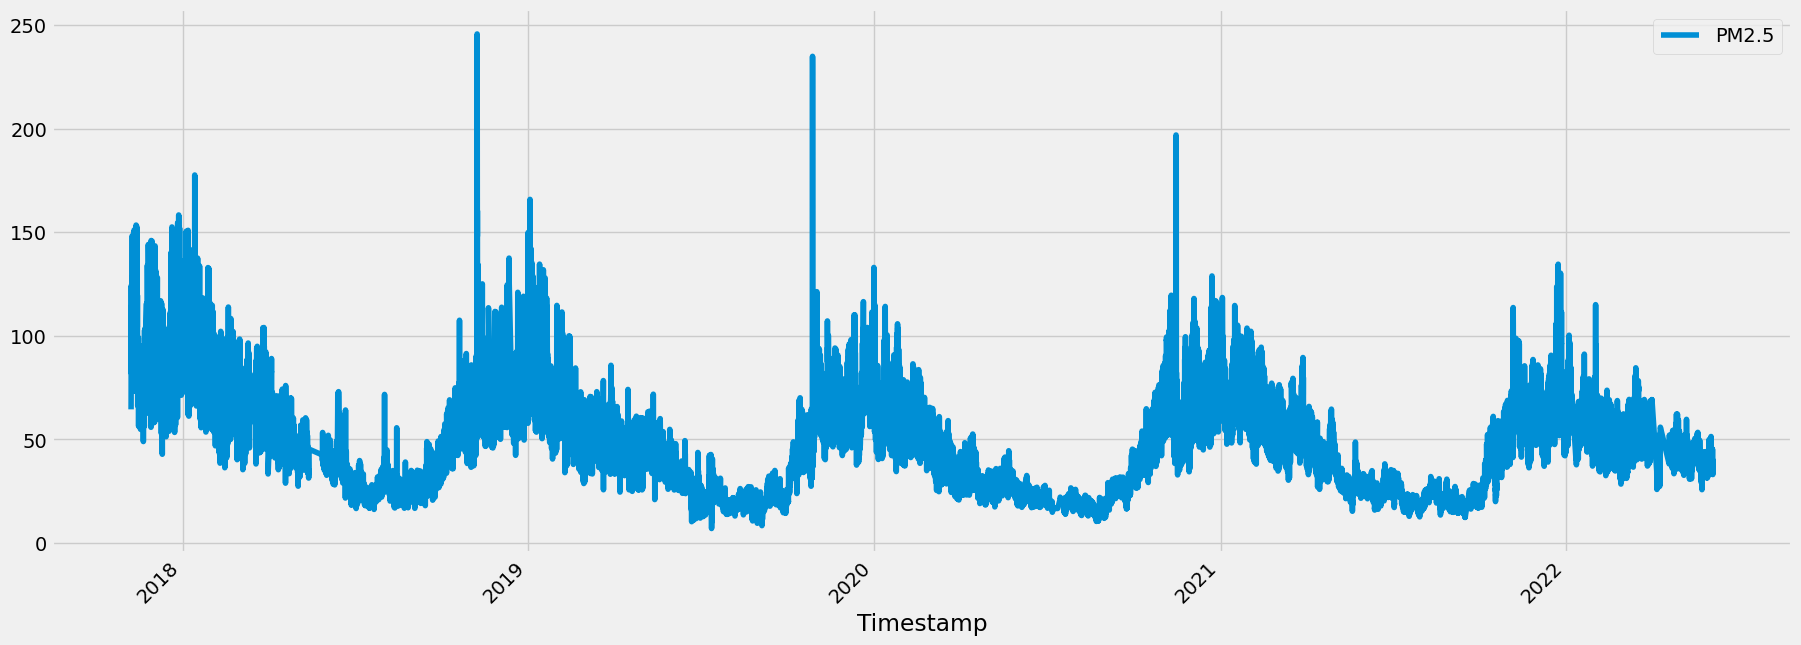

In [ ]:
df.plot(x='Timestamp',y='PM2.5',figsize=(20,8))
plt.xticks(rotation=45)

plt.show()

* 年平均の時系列

<Axes: xlabel='Year'>

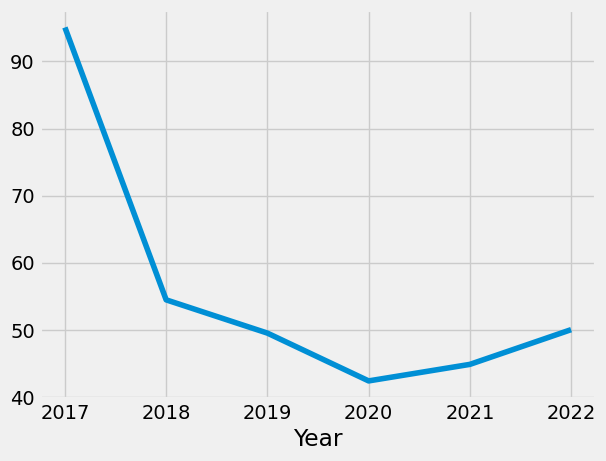

In [ ]:
df.groupby('Year')['PM2.5'].mean().plot()

* 年ごとのボックスプロット

<Axes: xlabel='Year', ylabel='PM2.5'>

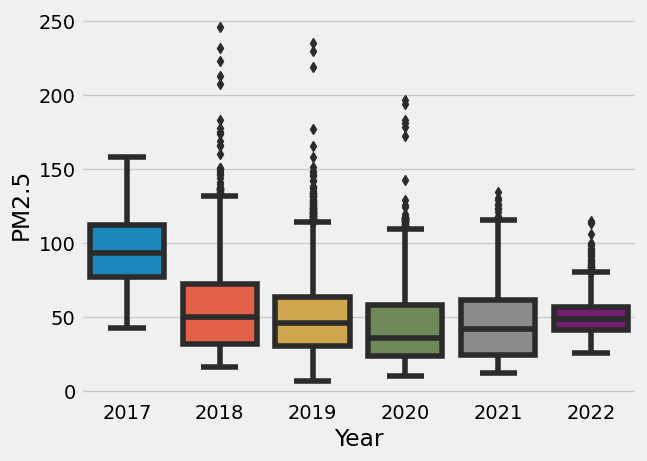

In [ ]:
df_year=df.loc[:,['Year','PM2.5']]
sns.boxplot(x='Year', y='PM2.5',data=df_year)

* 月平均の時系列

<Axes: xlabel='Month'>

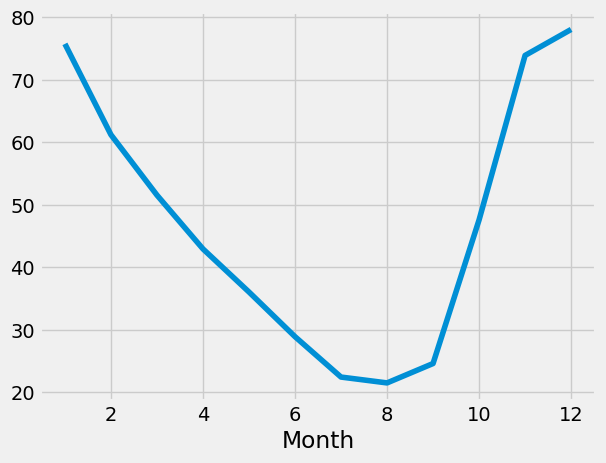

In [ ]:
df.groupby('Month')['PM2.5'].mean().plot()

* 月ごとのボックスプロット

<Axes: xlabel='Month', ylabel='PM2.5'>

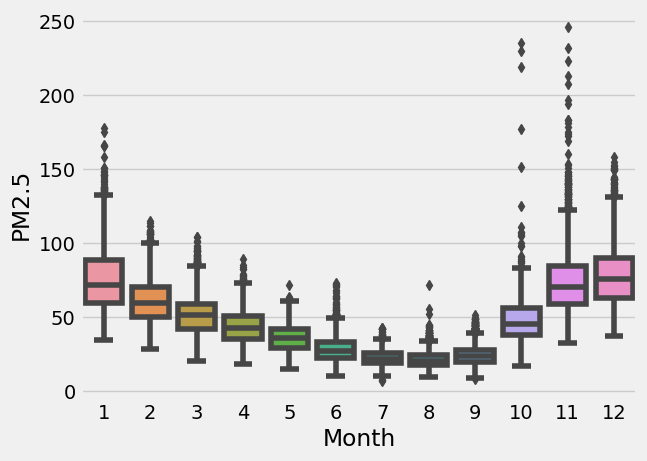

In [ ]:
df_month=df.loc[:,['Month','PM2.5']]
sns.boxplot(x='Month', y='PM2.5',data=df_month)

* 日平均の時系列

<Axes: xlabel='Day'>

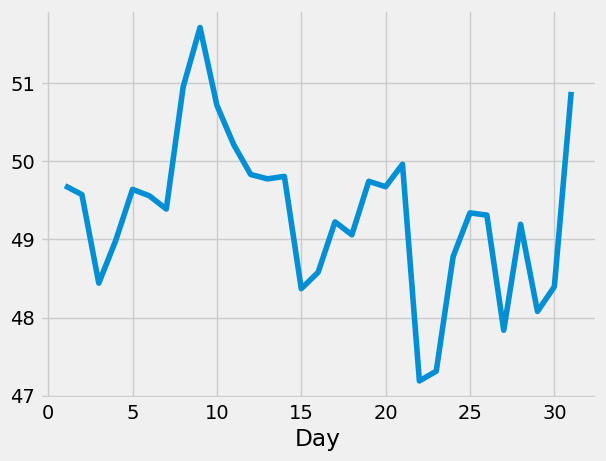

In [ ]:
df.groupby('Day')['PM2.5'].mean().plot()

* 日ごとのボックスプロット

<Axes: xlabel='Day', ylabel='PM2.5'>

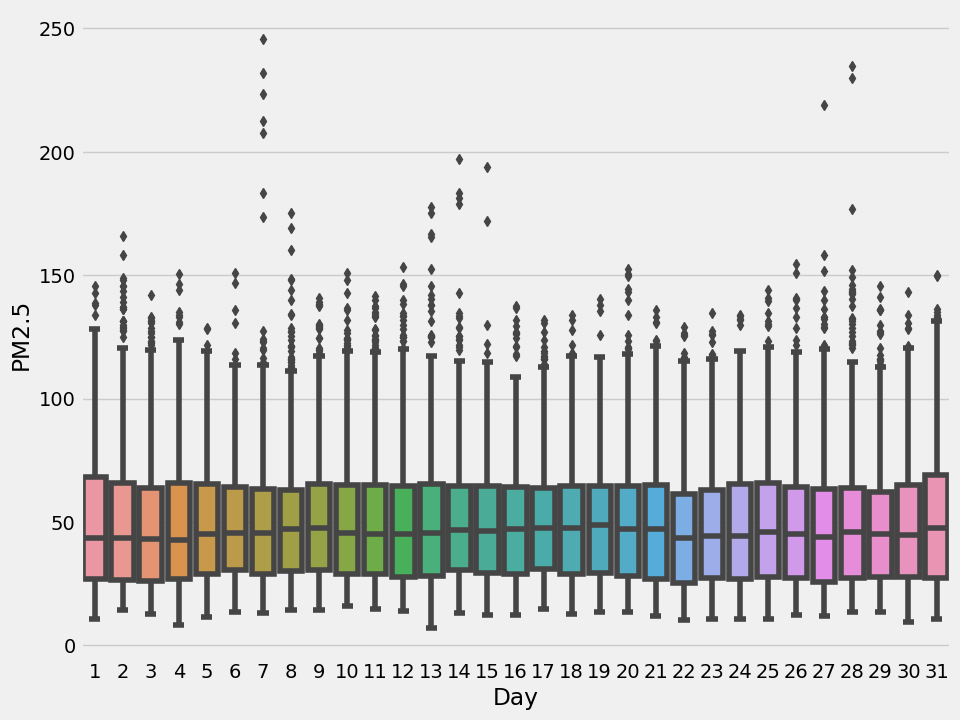

In [ ]:
df_day=df.loc[:,['Day','PM2.5']]
plt.figure(figsize=(10,8))
sns.boxplot(x='Day', y='PM2.5',data=df_day)

* 時間平均の時系列

<Axes: xlabel='Hour'>

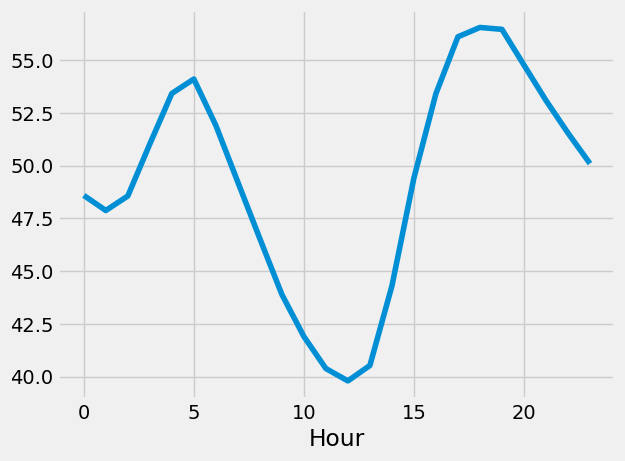

In [ ]:
df.groupby('Hour')['PM2.5'].mean().plot()

* 時間ごとのボックスプロット

<Axes: xlabel='Hour', ylabel='PM2.5'>

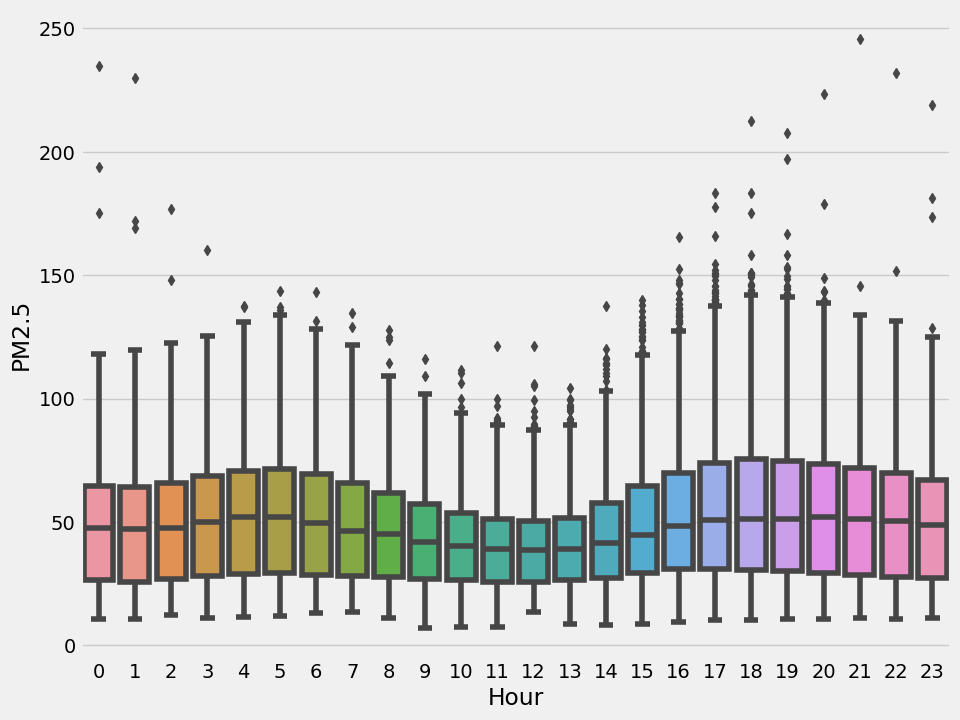

In [ ]:
df_hour=df.loc[:,['Hour','PM2.5']]
plt.figure(figsize=(10,8))
sns.boxplot(x='Hour', y='PM2.5',data=df_hour)

#####予測モデル

* 各日平均で予測モデルを考えてみました。そこで、まず、各日平均のデータセットを作成しました。

In [ ]:
df_date=pd.DataFrame(df.groupby('Date')['PM2.5'].mean())
df_date

,PM2.5
Date,
2017-11-07,99.805833
2017-11-08,110.979565
2017-11-09,114.915833
2017-11-10,119.404091
2017-11-11,109.267273
...,...
2022-05-31,41.465417
2022-06-01,41.645833
2022-06-02,42.255417


* 各日平均の時系列

<Axes: xlabel='Date'>

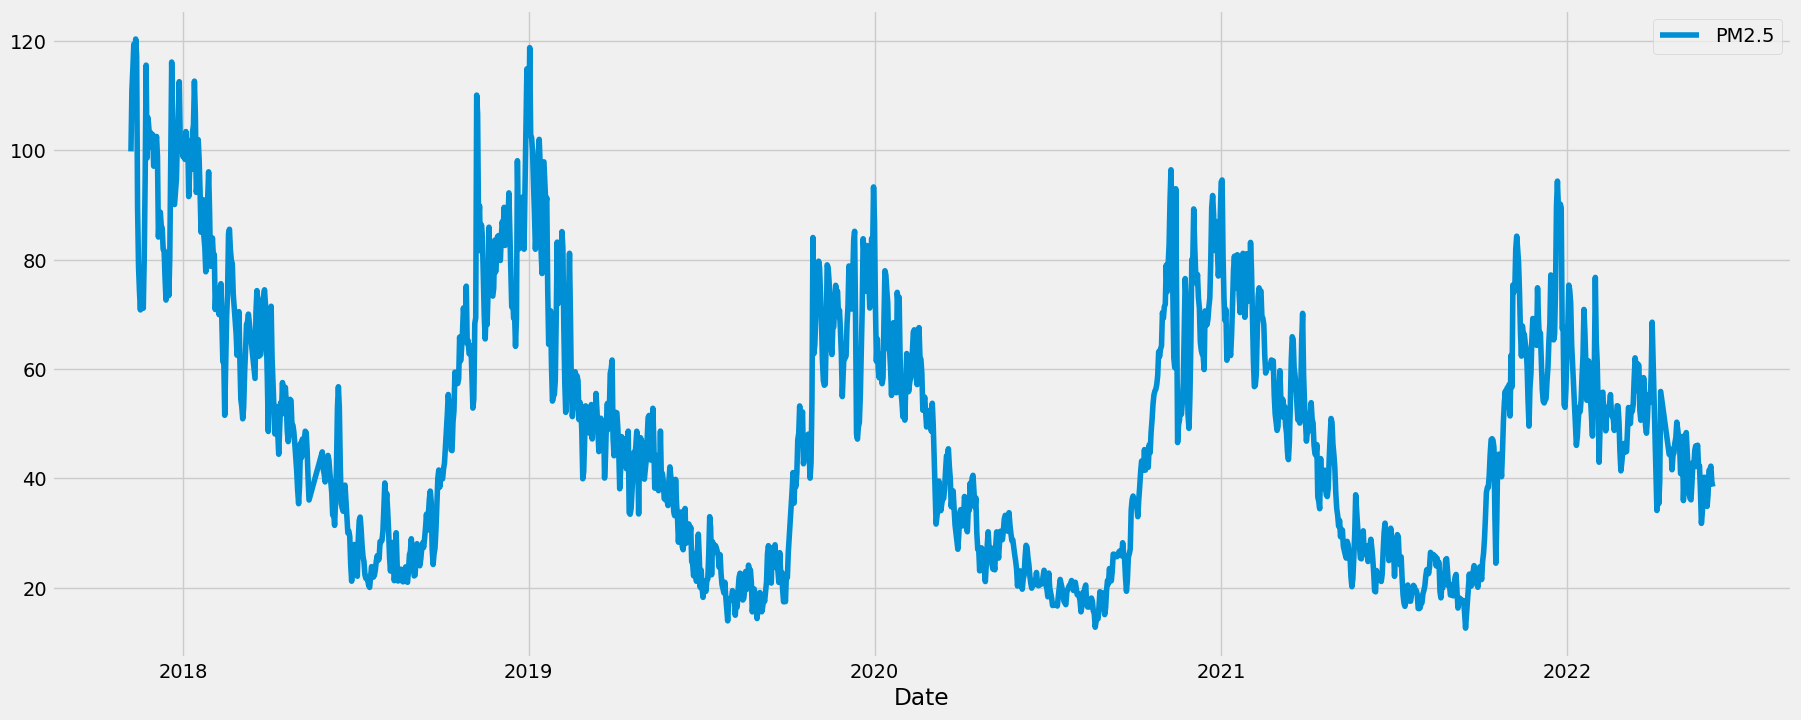

In [ ]:
df_date.plot(figsize=(20,8))

* データを訓練用80％、テスト用20％に分ける。

In [ ]:
dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1293

* MinMaxScalerによる標準化

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.80924161],
       [0.91297267],
       [0.94951492],
       ...,
       [0.27497376],
       [0.24870153],
       [0.24014526]])

In [ ]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1233, 60, 1)

* モデリング

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [ ]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

1233/1233 [==============================] - 47s 35ms/step - loss: 0.0068


* 予測

In [ ]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [ ]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

11/11 [==============================] - 1s 18ms/step


* RMSE(Root Mean Squared Error)とは、数値予測のモデルの良さを測る指標の一つです。低ければ低いほどよく、最良の場合 0 になります。

In [ ]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.3768986025130592

In [ ]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
valid

,PM2.5,Predictions
Date,,
2021-06-28,28.667917,24.767422
2021-06-29,30.903750,24.805368
2021-06-30,29.017917,25.816254
2021-07-01,27.166667,26.293501
2021-07-02,27.132917,25.981384
...,...,...
2022-05-31,41.465417,36.436554
2022-06-01,41.645833,37.866096
2022-06-02,42.255417,39.280533


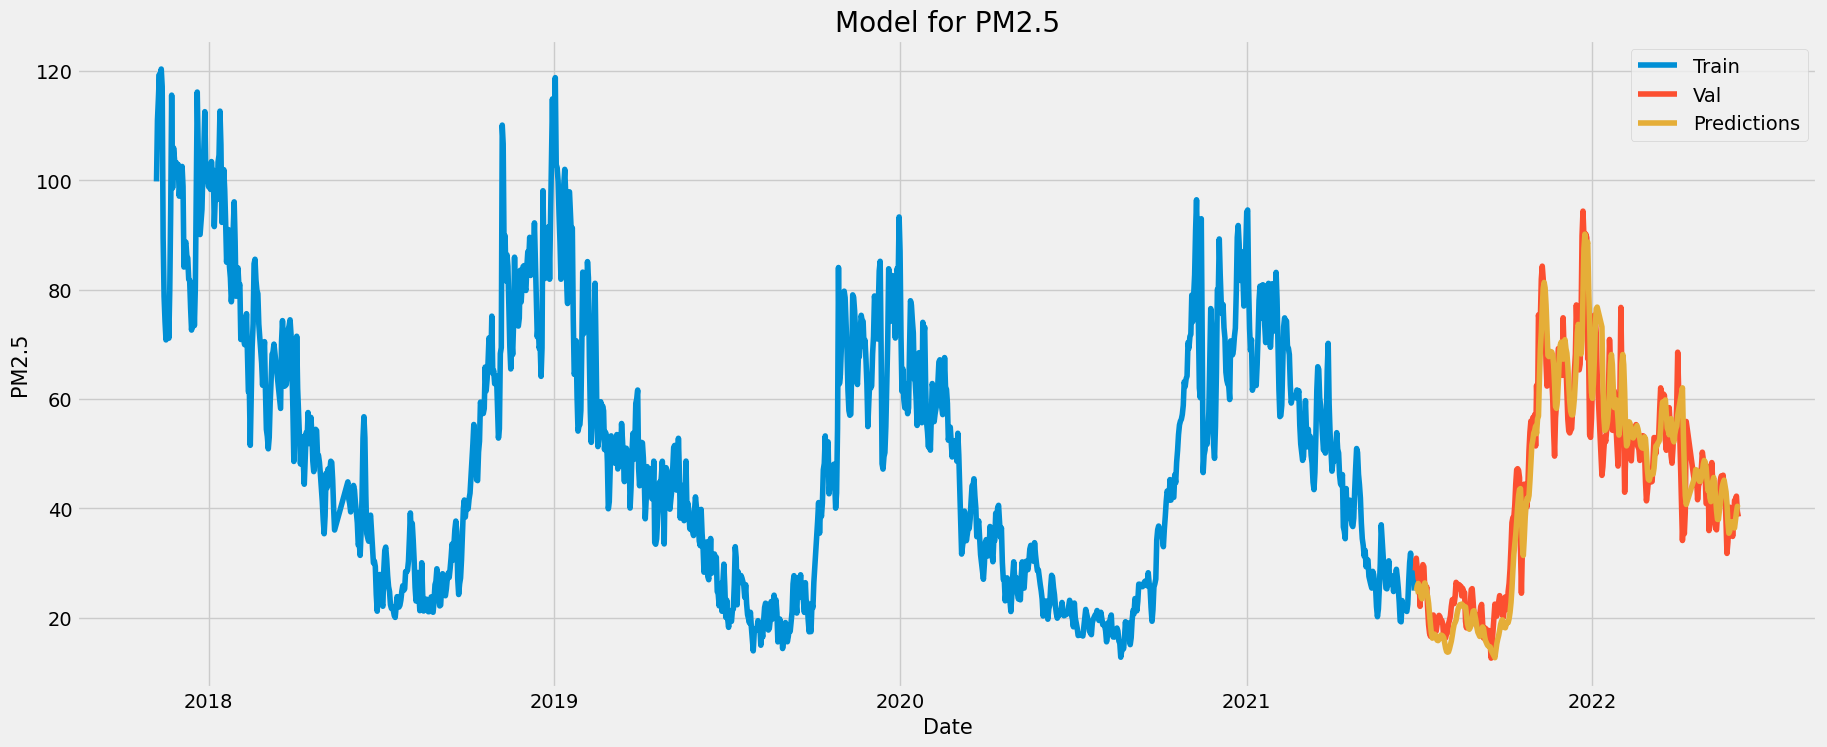

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Model for PM2.5")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("PM2.5",fontsize=15)
plt.plot(train[df_date.columns])
plt.plot(valid['PM2.5'])
plt.plot(valid["Predictions"])
plt.legend(["Train","Val","Predictions"])